# Neuro-Symbolic AI

## RFT Dataset

### Contents

- Generate Dataset
- Perception Model
- Semantic Parser
- Program Executor


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import cv2
from tqdm import tqdm 
from img_utils import *


In [10]:
# Generate the dataset

# Dataset params
img_size = 224
object_size = 15 # the object size?
question_size = 10 # 6 for one-hot vector of color, 1 for question type, 3 for question subtype
q_type_idx = 6 # type of question
sub_q_type_idx = 7 # 
nb_questions = 10 # questions per image. 

# Possibles Answers : [yes, no, rectangle, circle, 1, 2, 3, 4, 5, 6]

colors = [
    (0,0,255), # red
    (0,255,0), # green
    (255,0,0), # blue
    (0,156,255), # orange
    (128,128,128), # gray (128,128,128)- not working, replaced with black
    (0,255,255) # yellow - appears same as orange
]

# RFT Same-Different Data Generator

In [11]:

def build_sample():#colors, img_size, object_size):
    # choose two random colors
# for i in range(16):
    color1 = ()
    color2 = ()
    while color1 == color2:
        color1 = colors[random.randint(0,5)]
        color2 = colors[random.randint(0,5)]

    color1_id = colors.index(color1)
    color2_id = colors.index(color2)
    
    positions = [([25,25],[65,25]),([25,175],[65,175]),([160,25],[200,25]), ([160,175],[200,175])]
    random.shuffle(positions)

    objects = []

    img = np.ones((img_size,img_size,3)) * 255

    img, objects = draw_sCsS(img, positions, color1, color1_id, objects, size = object_size)
    img, objects = draw_sCdS(img, positions, color2, color2_id, objects, size = object_size)
    img, objects = draw_dCsS(img, positions, color1, color2, color1_id, color2_id, objects, size = object_size)
    img, objects = draw_dCdS(img, positions, color1, color2, color1_id, color2_id, objects, size = object_size)

    img = (img).astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return (img, objects)


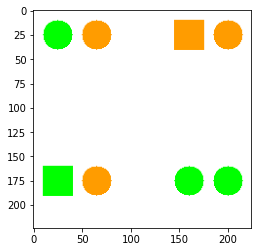

In [12]:
sample = build_sample()
plt.imshow(sample[0])

In [ ]:
# img_det_df = pd.DataFrame(columns=['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
# shape_map = {'r': 'rectangle', 'c': 'circle'}
# for obj in objects:
#   color_id, shape, bbox = obj[0], shape_map[obj[2]], obj[3]
#   print(color_id, shape, bbox)

In [19]:
# build_img_dataset with params colors, img_size, size

def make_directories(data_dir, img_dir):
    try:
        os.makedirs(data_dir)
    except:
        pass
    
    try:
        os.makedirs(img_dir)
    except:
        pass

def build_dataset(num_samples, data_dir, prefix='train'):
    
    samples = [build_sample() for _ in range(num_samples)]

        
    # Init dataframes
    img_det_df = pd.DataFrame(columns=['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
    que2prog_df = pd.DataFrame(columns=['filename', 'answer', 'query_text', 'program_text'])
    
    img_dir = os.path.join(data_dir, 'images')
    shape_map = {'r': 'rectangle', 'c': 'circle'}

    # generate data and image directories
    make_directories(data_dir, img_dir)

    for i, sample in enumerate(tqdm(samples)):
        img, objects = sample

        #save img
        filename = f'{i}.jpg'
        img_path = os.path.join(img_dir, filename)
        cv2.imwrite(img_path, img)

        # Append the image data to dataframes
        for obj in objects:
            color_id, shape, bbox = obj[0], shape_map[obj[2]], obj[3]
            
            img_det_df = img_det_df.append({'filename': filename, 
                                            'width': img_size, 
                                            'height': img_size, 
                                            'class': 'obj', 
                                            'xmin': bbox[0], 'ymin': bbox[1],
                                            'xmax': bbox[2], 'ymax': bbox[3]}, ignore_index=True)
            
            # Do the same for the text data (ignore for now)
                    # Append text data to dataframe

    img_det_df.to_csv(os.path.join(data_dir, f'{prefix}_img_det.csv'), index=False)
    

In [20]:
n_train_imgs = 50
build_dataset(n_train_imgs, data_dir='data/train', prefix='train') # only vision stuff for now

# Biuld Questions

In [13]:
def fill_q_template(idx):
    question_types = [['the same color', 'the same shape'],['the same color','a different shape'],\
        ['a different color','the same shape'], ['a different color','a different shape']]
    
    order = [0,1]
    random.shuffle(order)
    return f'Which pair is {question_types[idx][order[0]]} and {question_types[idx][order[1]]}?'


In [14]:
questions = [fill_q_template(i) for i in [0,1,2,3]]
random.shuffle(questions)
questions

['Which pair is the same shape and a different color?',
 'Which pair is a different shape and the same color?',
 'Which pair is the same color and the same shape?',
 'Which pair is a different color and a different shape?']

In [ ]:
# Generate training dataset
# programs
